### Direct Search
Likely to be MORDM
1) Initialize Model/ Problem Specification
2) Search Candidate Solutions (based on Ref Scenario)
3) Re-Evaluate Solutions under Uncertainty (Many Scenario)
4) Save Results

In [61]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# EMA
from ema_workbench import (Model, RealParameter,  Scenario, MultiprocessingEvaluator, ScalarOutcome, perform_experiments, ema_logging)
from ema_workbench import Samplers, Policy
from ema_workbench import save_results, load_results
from ema_workbench.em_framework.optimization import EpsilonProgress, HyperVolume
from ema_workbench.analysis import parcoords
# Model
from problem_formulation import get_model_for_problem_formulation
ema_logging.log_to_stderr(ema_logging.INFO)
# parameter definition for visualization libraries
plt.rcParams["figure.figsize"] = (10, 6)
sns.set_style("whitegrid")

### 1) Initialize Model

In [2]:
#------------------------- Set Model Parameters
problem_formulation = 6
model, steps = get_model_for_problem_formulation(problem_formulation)

uncertainties = model.uncertainties
levers = model.levers
outcomes = model.outcomes

#------------------------- Reference Scenario
ref_val = {'Bmax': 175, 
           'Brate': 1.5, 
           'pfail': 0.5,
            'discount rate': 3.5,
            'ID flood wave shape': 4}

ref_dict = {}
# < ref_dict >
# reference scenario updated for all dike rings
for key in model.uncertainties:
    name_split = key.name.split('_')
    if len(name_split) == 1:
        if key.name in ref_val.keys():
            ref_dict.update({key.name: ref_val[key.name]})
    else:
        ref_dict.update({key.name: ref_val[name_split[1]]})


#------------------------- Optimization Parameters

ref_scenario = Scenario('reference', **ref_dict)

convergence_metrics = [EpsilonProgress()]
nfe = 50000

In [6]:
for policy in model.levers:
    print(repr(policy))

IntegerParameter('0_RfR 0', 0, 1, resolution=None, default=None, variable_name=['0_RfR 0'], pff=False)
IntegerParameter('1_RfR 0', 0, 1, resolution=None, default=None, variable_name=['1_RfR 0'], pff=False)
IntegerParameter('2_RfR 0', 0, 1, resolution=None, default=None, variable_name=['2_RfR 0'], pff=False)
IntegerParameter('3_RfR 0', 0, 1, resolution=None, default=None, variable_name=['3_RfR 0'], pff=False)
IntegerParameter('4_RfR 0', 0, 1, resolution=None, default=None, variable_name=['4_RfR 0'], pff=False)
IntegerParameter('EWS_DaysToThreat', 0, 1, resolution=None, default=None, variable_name=['EWS_DaysToThreat'], pff=False)
IntegerParameter('A.1_DikeIncrease 0', 0, 10, resolution=None, default=None, variable_name=['A.1_DikeIncrease 0'], pff=False)
IntegerParameter('A.2_DikeIncrease 0', 0, 10, resolution=None, default=None, variable_name=['A.2_DikeIncrease 0'], pff=False)
IntegerParameter('A.3_DikeIncrease 0', 0, 10, resolution=None, default=None, variable_name=['A.3_DikeIncrease 0'

### 2) Search Candidate Solutions (based on Ref Scenario)
- Run Optimization on Lever Space
- Find Candidate Policies

In [7]:


ema_logging.log_to_stderr(ema_logging.INFO)
with MultiprocessingEvaluator(model, n_processes = 6) as evaluator:
    results1, convergence = evaluator.optimize(nfe=nfe,
                                            searchover='levers',
                                            epsilons=[0.1]*len(model.outcomes),
                                              convergence=convergence_metrics,
                                            reference=ref_scenario
                                            )
    
results1.to_csv('results/optimization_{}_{}_noEWS.csv'.format(problem_formulation,nfe))



[MainProcess/INFO] pool started with 6 workers
50060it [1:55:37,  7.22it/s]                                                   
[MainProcess/INFO] optimization completed, found 8108 solutions
[MainProcess/INFO] terminating pool


In [62]:
# final result data set
results = pd.read_csv("results/optimization_6_50000_noEWS.csv")
results

,Unnamed: 0,0_RfR 0,1_RfR 0,2_RfR 0,3_RfR 0,4_RfR 0,EWS_DaysToThreat,A.1_DikeIncrease 0,A.2_DikeIncrease 0,A.3_DikeIncrease 0,...,A.3_Dike Investment Costs,A.3_Expected Number of Deaths,A.4_Expected Annual Damage,A.4_Dike Investment Costs,A.4_Expected Number of Deaths,A.5_Expected Annual Damage,A.5_Dike Investment Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs
0,0,1,1,1,1,1,0,0,3,1,...,2.029929e+07,0.012657,6.099298e+06,0.000000e+00,0.001223,0.000000e+00,4.027367e+07,0.000000,710400000.0,0.0
1,1,1,0,0,0,0,0,0,3,6,...,3.139880e+07,0.000000,0.000000e+00,1.106877e+07,0.000000,0.000000e+00,3.337712e+07,0.000000,84600000.0,0.0
2,2,1,1,1,1,1,0,1,4,1,...,2.029929e+07,0.012657,6.099298e+06,0.000000e+00,0.001223,0.000000e+00,5.817663e+07,0.000000,710400000.0,0.0
3,3,0,1,0,0,1,1,5,1,0,...,0.000000e+00,0.091438,2.591086e+06,0.000000e+00,0.000511,0.000000e+00,2.757823e+07,0.000000,473900000.0,0.0
4,4,1,0,0,0,0,1,0,4,0,...,0.000000e+00,0.092239,0.000000e+00,1.426165e+07,0.000000,0.000000e+00,3.337712e+07,0.000000,84600000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8103,8103,0,0,1,1,1,1,2,4,0,...,0.000000e+00,0.030772,0.000000e+00,1.258646e+07,0.000000,1.462522e+07,0.000000e+00,0.005190,408000000.0,0.0
8104,8104,1,0,1,0,0,0,0,10,3,...,2.419803e+07,0.000000,7.114656e+06,6.320800e+06,0.001575,5.084397e+07,2.503721e+07,0.018235,115300000.0,0.0
8105,8105,1,0,0,1,0,0,2,3,1,...,2.029929e+07,0.031913,9.156879e+06,0.000000e+00,0.001797,1.462522e+07,0.000000e+00,0.005190,205800000.0,0.0
8106,8106,1,0,1,1,1,0,1,5,6,...,3.139880e+07,0.000000,3.705277e+06,6.320800e+06,0.000780,0.000000e+00,2.757823e+07,0.000000,492600000.0,0.0


In [4]:
results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8108 entries, 0 to 8107
Data columns (total 29 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Unnamed: 0                     8108 non-null   int64  
 1   0_RfR 0                        8108 non-null   int64  
 2   1_RfR 0                        8108 non-null   int64  
 3   2_RfR 0                        8108 non-null   int64  
 4   3_RfR 0                        8108 non-null   int64  
 5   4_RfR 0                        8108 non-null   int64  
 6   EWS_DaysToThreat               8108 non-null   int64  
 7   A.1_DikeIncrease 0             8108 non-null   int64  
 8   A.2_DikeIncrease 0             8108 non-null   int64  
 9   A.3_DikeIncrease 0             8108 non-null   int64  
 10  A.4_DikeIncrease 0             8108 non-null   int64  
 11  A.5_DikeIncrease 0             8108 non-null   int64  
 12  A.1_Expected Annual Damage     8108 non-null   f

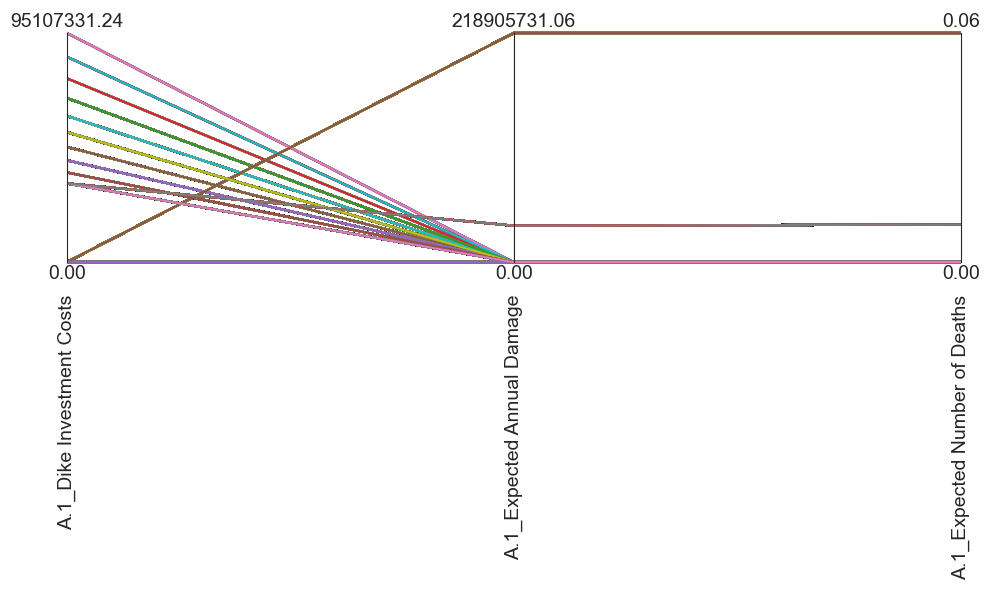

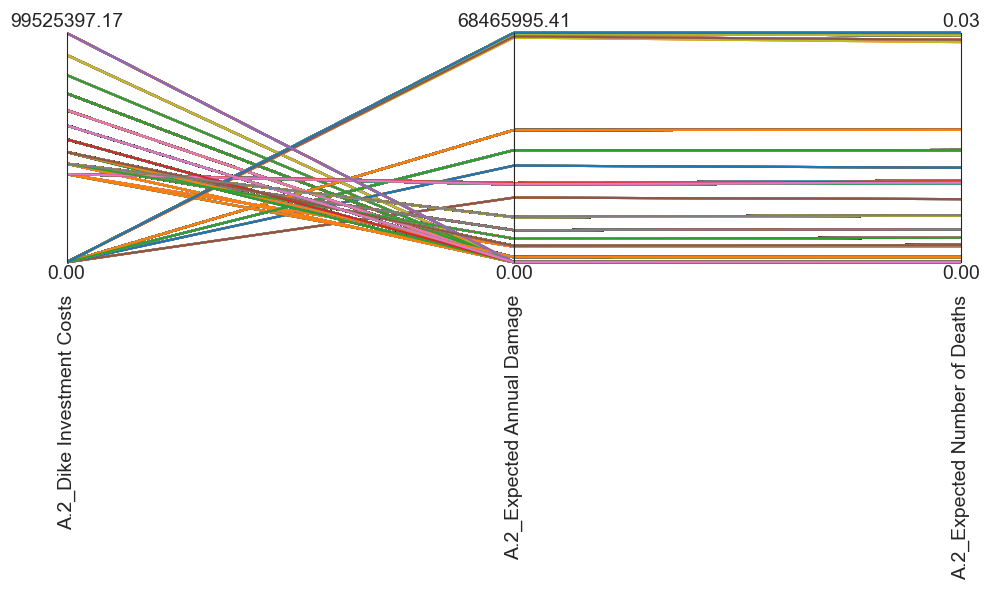

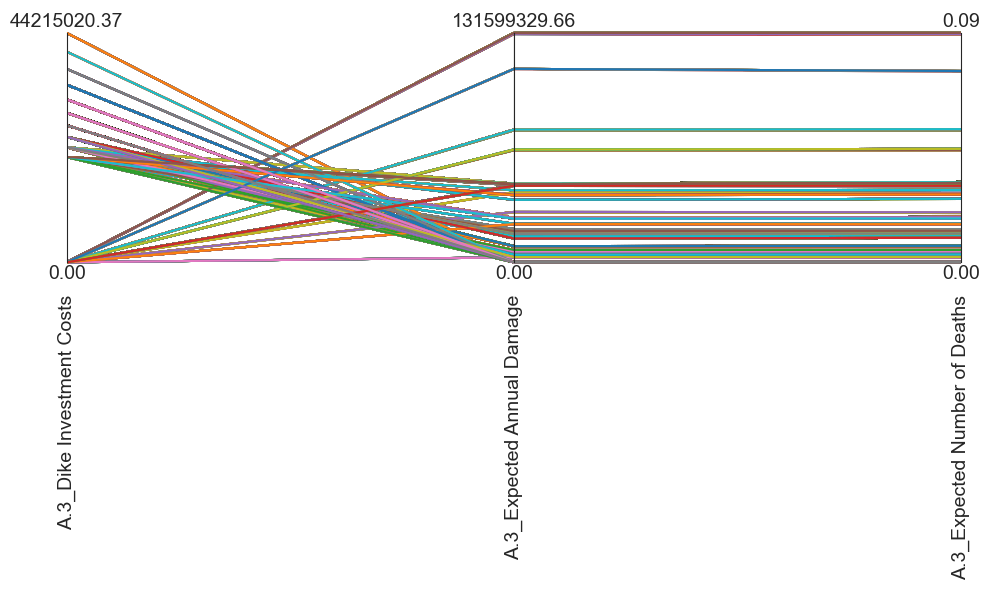

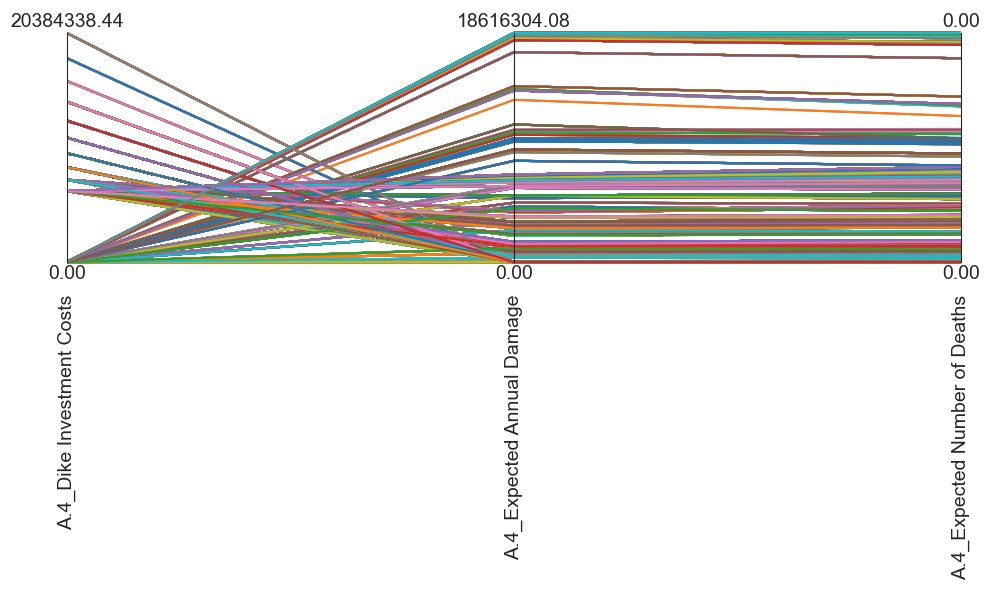

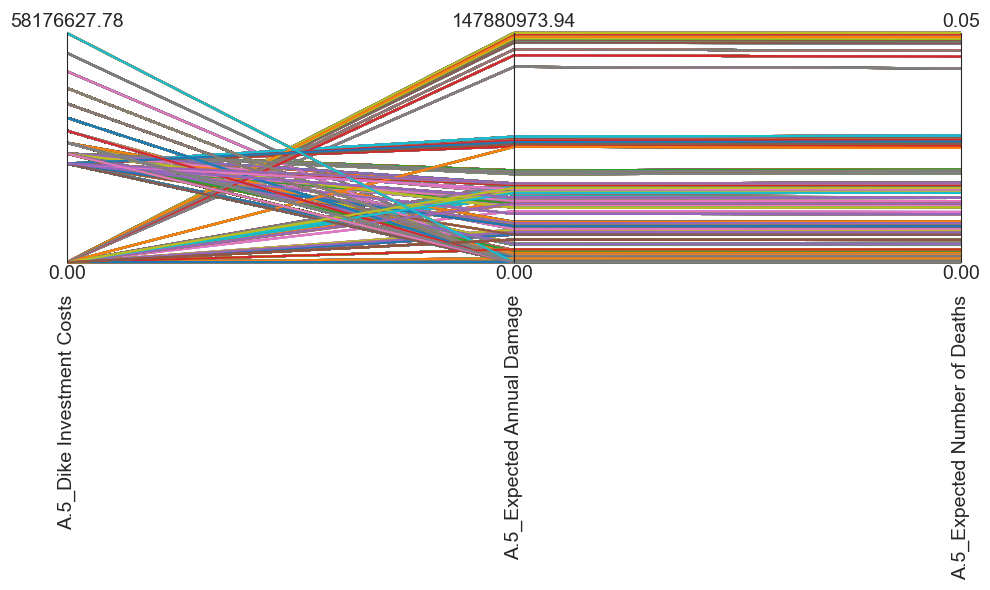

In [34]:
#gives results across each of the dike rings for problem_formulation (3)
for i in range(5):

        data = results.loc[:, [f"A.{i+1}_Dike Investment Costs",
                               f"A.{i+1}_Expected Annual Damage",
                               f"A.{i+1}_Expected Number of Deaths",
                               ]]
        
        limits = parcoords.get_limits(data)
        limits.loc[0, [f"A.{i+1}_Expected Annual Damage",
                               f"A.{i+1}_Expected Number of Deaths",
                               f"A.{i+1}_Dike Investment Costs",
                               ]] = 0

        paraxes = parcoords.ParallelAxes(limits)
        paraxes.plot(data)
        
        
        plt.show()
        

### 3) Re-Evaluate Solutions under Uncertainty (Few Candidate Policies, Many Scenario)


#### 3a Constrain Conditions

In [73]:
#Create aggregate columns for death, damage and investment cost
results["Gelderland_Deaths"] = results[[f"A.{i+1}_Expected Number of Deaths" for i in range(3)]].sum(axis=1)
results["Gelderland_Damages"] = results[[f"A.{i+1}_Expected Annual Damage" for i in range(3)]].sum(axis=1)
results["Gelderland_Investment"] = results[[f"A.{i+1}_Dike Investment Costs" for i in range(3)]].sum(axis=1)
results["Overijssel_Deaths"] = results[[f"A.{i}_Expected Number of Deaths" for i in [4, 5]]].sum(axis=1)
results["Overijssel_Damages"] = results[[f"A.{i}_Expected Annual Damage" for i in [4, 5]]].sum(axis=1)
results["Overijssel_Investment"] = results[[f"A.{i}_Dike Investment Costs" for i in [4, 5]]].sum(axis=1)
results["Total_Deaths"] = results["Gelderland_Deaths"] + results["Overijssel_Deaths"]
results["Total_Damages"] = results["Gelderland_Damages"] + results["Overijssel_Damages"]
results["Total_Investment"] = results["Gelderland_Investment"] + results["Overijssel_Investment"]
results["Gelderland_RfR"] = results[[f"{i}_RfR 0" for i in range(3)]].sum(axis=1)
results["Overijssel_RfR"] = results[[f"{i}_RfR 0" for i in [3, 4]]].sum(axis=1)

results

,Unnamed: 0,0_RfR 0,1_RfR 0,2_RfR 0,3_RfR 0,4_RfR 0,EWS_DaysToThreat,A.1_DikeIncrease 0,A.2_DikeIncrease 0,A.3_DikeIncrease 0,...,Gelderland_Damages,Gelderland_Investment,Overijssel_Deaths,Overijssel_Damages,Overijssel_Investment,Total_Deaths,Total_Damages,Total_Investment,Gelderland_RfR,Overijssel_RfR
0,0,1,1,1,1,1,0,0,3,1,...,1.951891e+07,6.814199e+07,0.001223,6.099298e+06,4.027367e+07,0.014495,2.561820e+07,1.084157e+08,3,2
1,1,1,0,0,0,0,0,0,3,6,...,4.924467e+06,7.924150e+07,0.000000,0.000000e+00,4.444589e+07,0.001920,4.924467e+06,1.236874e+08,1,0
2,2,1,1,1,1,1,0,1,4,1,...,1.793119e+07,1.063528e+08,0.001223,6.099298e+06,5.817663e+07,0.013881,2.403049e+07,1.645294e+08,3,2
3,3,0,1,0,0,1,1,5,1,0,...,1.546264e+08,9.221763e+07,0.000511,2.591086e+06,2.757823e+07,0.100968,1.572175e+08,1.197959e+08,1,1
4,4,1,0,0,0,0,1,0,4,0,...,1.315993e+08,5.335857e+07,0.000000,0.000000e+00,4.763877e+07,0.092239,1.315993e+08,1.009973e+08,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8103,8103,0,0,1,1,1,1,2,4,0,...,4.394483e+07,9.061378e+07,0.005190,1.462522e+07,1.258646e+07,0.035962,5.857004e+07,1.032002e+08,1,2
8104,8104,1,0,1,0,0,0,0,10,3,...,0.000000e+00,1.237234e+08,0.019810,5.795862e+07,3.135801e+07,0.019810,5.795862e+07,1.550814e+08,2,0
8105,8105,1,0,0,1,0,0,2,3,1,...,4.974352e+07,1.053972e+08,0.006986,2.378210e+07,0.000000e+00,0.040802,7.352562e+07,1.053972e+08,1,1
8106,8106,1,0,1,1,1,0,1,5,6,...,0.000000e+00,1.235038e+08,0.000780,3.705277e+06,3.389903e+07,0.000780,3.705277e+06,1.574028e+08,2,2


In [86]:
#Political Filter
""" 
RFR on both provinces if any
Dike Increase > 5 on dike rin 3 and dike ring 5
Total Cost < 700 mio
 """
policies = results[(results["A.3_DikeIncrease 0"] > 5) & (results["A.5_DikeIncrease 0"] > 5)]
print(len(policies))
policies = policies[policies["Total_Investment"] < 180*10**6]
print(len(policies))
policies = policies[((policies["Gelderland_RfR"] > 0)&(policies["Overijssel_RfR"] > 0)) | ((policies["Gelderland_RfR"] == 0)&(policies["Overijssel_RfR"] == 0))]
print(len(policies))
""" #Set threshiold for priority 1, 2 and 3: Deaths, Damages and Investment costs
distribution_threshold_deaths = 0.1
distribution_threshold_damages = 0.1
distribution_threshold_investment = 0.1
#Refine Policies-Dataframe to fit Priority 1 criterion
results2 = results.sort_values("Total_Deaths")
results2 = results.iloc[0:int(len(results2)*distribution_threshold_deaths),:]

#Refine Policies-Dataframe to fit Priority 2 criterion
results3 = results2.sort_values("Gelderland_Damages")
results3 = results3.iloc[0:int(len(results3)*distribution_threshold_damages),:]

#Refine Policies-Dataframe to fit Priority 3 criterion
results4 = results3.sort_values("Overijssel_Investment")
policies = results4.iloc[0:int(len(results4)*distribution_threshold_investment),:]
 """
pd.options.display.max_columns = None
display(policies)

49
39
13


,Unnamed: 0,0_RfR 0,1_RfR 0,2_RfR 0,3_RfR 0,4_RfR 0,EWS_DaysToThreat,A.1_DikeIncrease 0,A.2_DikeIncrease 0,A.3_DikeIncrease 0,A.4_DikeIncrease 0,A.5_DikeIncrease 0,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.1_Expected Number of Deaths,A.2_Expected Annual Damage,A.2_Dike Investment Costs,A.2_Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Dike Investment Costs,A.3_Expected Number of Deaths,A.4_Expected Annual Damage,A.4_Dike Investment Costs,A.4_Expected Number of Deaths,A.5_Expected Annual Damage,A.5_Dike Investment Costs,A.5_Expected Number of Deaths,RfR Total Costs,Expected Evacuation Costs,Gelderland_Deaths,Gelderland_Damages,Gelderland_Investment,Overijssel_Deaths,Overijssel_Damages,Overijssel_Investment,Total_Deaths,Total_Damages,Total_Investment,Gelderland_RfR,Overijssel_RfR
643,643,0,0,0,0,0,1,1,4,7,1,7,3.485665e+07,3.269490e+07,0.009838,0.000000e+00,5.335857e+07,0.000000,0.0,3.422156e+07,0.0,6.932928e+06,6.320800e+06,0.001512,0.0,4.419351e+07,0.0,0.0,0.0,0.009838,3.485665e+07,1.202750e+08,0.001512,6.932928e+06,5.051431e+07,0.011349,4.178958e+07,1.707893e+08,0,0
957,957,0,0,0,0,0,0,1,5,7,3,6,3.485665e+07,3.269490e+07,0.009838,0.000000e+00,5.941010e+07,0.000000,0.0,3.422156e+07,0.0,0.000000e+00,8.453407e+06,0.000000,0.0,4.027367e+07,0.0,0.0,0.0,0.009838,3.485665e+07,1.263266e+08,0.000000,0.000000e+00,4.872708e+07,0.009838,3.485665e+07,1.750536e+08,0,0
1609,1609,0,1,1,1,1,0,2,4,6,1,6,0.000000e+00,3.725520e+07,0.000000,0.000000e+00,5.335857e+07,0.000000,0.0,3.139880e+07,0.0,3.705277e+06,6.320800e+06,0.000780,0.0,4.027367e+07,0.0,625800000.0,0.0,0.000000,0.000000e+00,1.220126e+08,0.000780,3.705277e+06,4.659447e+07,0.000780,3.705277e+06,1.686070e+08,2,2
2651,2651,0,0,0,0,0,0,1,3,6,2,6,3.485665e+07,3.269490e+07,0.009838,4.924467e+06,4.784270e+07,0.001920,0.0,3.139880e+07,0.0,3.276989e+06,7.332080e+06,0.000725,0.0,4.027367e+07,0.0,0.0,0.0,0.011758,3.978112e+07,1.119364e+08,0.000725,3.276989e+06,4.760575e+07,0.012483,4.305811e+07,1.595421e+08,0,0
3336,3336,0,0,1,1,0,0,2,3,6,2,7,0.000000e+00,3.725520e+07,0.000000,1.587714e+06,4.784270e+07,0.000615,0.0,3.139880e+07,0.0,1.452903e+06,7.332080e+06,0.000323,0.0,4.419351e+07,0.0,151900000.0,0.0,0.000615,1.587714e+06,1.164967e+08,0.000323,1.452903e+06,5.152559e+07,0.000937,3.040617e+06,1.680223e+08,1,1
4079,4079,0,0,1,1,1,0,2,3,6,2,9,0.000000e+00,3.725520e+07,0.000000,1.587714e+06,4.784270e+07,0.000615,0.0,3.139880e+07,0.0,0.000000e+00,7.332080e+06,0.000000,0.0,5.311400e+07,0.0,408000000.0,0.0,0.000615,1.587714e+06,1.164967e+08,0.000000,0.000000e+00,6.044608e+07,0.000615,1.587714e+06,1.769428e+08,1,2
4084,4084,0,1,1,1,0,1,2,3,7,2,7,0.000000e+00,3.725520e+07,0.000000,1.587714e+06,4.784270e+07,0.000615,0.0,3.422156e+07,0.0,1.452903e+06,7.332080e+06,0.000323,0.0,4.419351e+07,0.0,369700000.0,0.0,0.000615,1.587714e+06,1.193195e+08,0.000323,1.452903e+06,5.152559e+07,0.000937,3.040617e+06,1.708451e+08,2,1
4431,4431,1,1,1,1,1,0,0,2,7,2,6,0.000000e+00,0.000000e+00,0.000000,7.087017e+06,4.281842e+07,0.002708,0.0,3.422156e+07,0.0,0.000000e+00,7.332080e+06,0.000000,0.0,4.027367e+07,0.0,710400000.0,0.0,0.002708,7.087017e+06,7.703998e+07,0.000000,0.000000e+00,4.760575e+07,0.002708,7.087017e+06,1.246457e+08,3,2
4755,4755,0,0,1,1,0,1,4,3,6,2,6,0.000000e+00,4.784795e+07,0.000000,1.587714e+06,4.784270e+07,0.000615,0.0,3.139880e+07,0.0,1.452903e+06,7.332080e+06,0.000323,0.0,4.027367e+07,0.0,151900000.0,0.0,0.000615,1.587714e+06,1.270894e+08,0.000323,1.452903e+06,4.760575e+07,0.000937,3.040617e+06,1.746952e+08,1,1
5236,5236,0,0,0,0,0,0,3,4,6,5,6,0.000000e+00,4.229151e+07,0.000000,0.000000e+00,5.335857e+07,0.000000,0.0,3.139880e+07,0.0,0.000000e+00,1.106877e+07,0.000000,0.0,4.027367e+07,0.0,0.0,0.0,0.000000,0.000000e+00,1.270489e+08,0.000000,0.000000e+00,5.134244e+07,0.000000,0.000000e+00,1.783913e+08,0,0


In [57]:
#show 504
policies.iloc[2]

Unnamed: 0                       1.150000e+02
0_RfR 0                          1.000000e+00
1_RfR 0                          1.000000e+00
2_RfR 0                          1.000000e+00
3_RfR 0                          1.000000e+00
4_RfR 0                          0.000000e+00
EWS_DaysToThreat                 0.000000e+00
A.1_DikeIncrease 0               0.000000e+00
A.2_DikeIncrease 0               2.000000e+00
A.3_DikeIncrease 0               4.000000e+00
A.4_DikeIncrease 0               3.000000e+00
A.5_DikeIncrease 0               3.000000e+00
A.1_Expected Annual Damage       0.000000e+00
A.1_Dike Investment Costs        0.000000e+00
A.1_Expected Number of Deaths    0.000000e+00
A.2_Expected Annual Damage       7.087017e+06
A.2_Dike Investment Costs        4.281842e+07
A.2_Expected Number of Deaths    2.708211e-03
A.3_Expected Annual Damage       0.000000e+00
A.3_Dike Investment Costs        2.640338e+07
A.3_Expected Number of Deaths    0.000000e+00
A.4_Expected Annual Damage       0

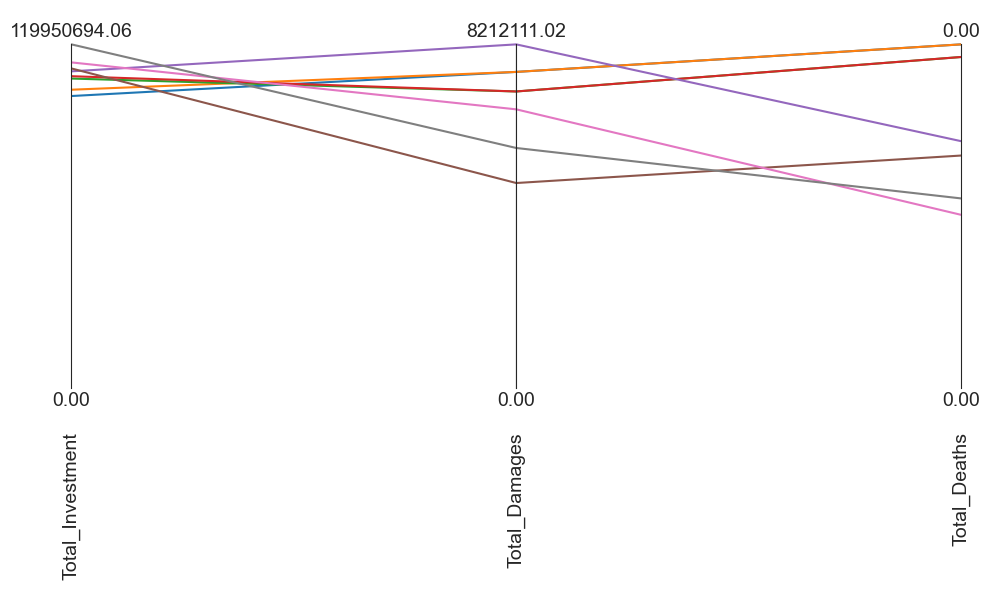

In [35]:



data = policies.loc[:, ["Total_Investment",
                        "Total_Damages",
                        "Total_Deaths",
                        ]]

limits = parcoords.get_limits(data)
limits.loc[0, [  "Total_Investment",
                        "Total_Damages",
                        "Total_Deaths",
                        ]] = 0

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)


plt.show()


#### 3b Robustness Analysis (Run Scenarios)

In [10]:

n_scenarios = 1000
# Policies are subsequently collected in a list as policy objects
policies_to_evaluate = []

for i, policy in policies.iterrows():
    policies_to_evaluate.append(Policy(str(i), **policy.to_dict()))


In [11]:

with MultiprocessingEvaluator(model) as evaluator:
    rob_results = evaluator.perform_experiments(n_scenarios,
                                            policies_to_evaluate)
    
save_results(rob_results, 'results/MORDM2.tar.gz')



[MainProcess/INFO] pool started with 4 workers
[MainProcess/INFO] performing 1000 scenarios * 8 policies * 1 model(s) = 8000 experiments
100%|██████████████████████████████████████| 8000/8000 [22:24<00:00,  5.95it/s]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool
[MainProcess/INFO] results saved successfully to /Users/alex/Documents/GitHub/model-based-decision-making/final_assignment/results/MORDM2.tar.gz


In [12]:
rob_results = load_results ('results/MORDM2.tar.gz')

[MainProcess/INFO] results loaded successfully from /Users/alex/Documents/GitHub/model-based-decision-making/final_assignment/results/MORDM2.tar.gz


#### 3c Visualize Results
1) Signal to Noise Ratio
2) Calculate Maximum regret
3) Scenario Dicovery to understand bad conditions

##### 3c1 Signal to Noise Ratio

In [13]:
#signal to noise - high value for maximizable outcomes is desirable
#outcome to have high average value and low standard deviation

def s_to_n(data, direction):
    mean = np.mean(data)
    std = np.std(data)
    
    if direction==ScalarOutcome.MAXIMIZE:
        return mean/std
    else:
        return mean*std

In [27]:
experiments, outcomes = rob_results

df = pd.DataFrame(outcomes)

In [32]:
df

,A.1_Expected Annual Damage,A.1_Dike Investment Costs,A.1_Expected Number of Deaths,A.2_Expected Annual Damage,A.2_Dike Investment Costs,A.2_Expected Number of Deaths,A.3_Expected Annual Damage,A.3_Dike Investment Costs,A.3_Expected Number of Deaths,A.4_Expected Annual Damage,...,Expected Evacuation Costs,Gelderland_Deaths,Gelderland_Damages,Gelderland_Investment,Overijssel_Deaths,Overijssel_Damages,Overijssel_Investment,Total_Deaths,Total_Damages,Total_Investment
0,0.000000e+00,0,0.000000,4.303418e+07,4.281842e+07,0.045916,0.000000e+00,2.419803e+07,0.000000,0.000000e+00,...,0.0,0.045916,4.303418e+07,6.701645e+07,0.000000,0.000000e+00,3.491031e+07,0.045916,4.303418e+07,1.019268e+08
1,0.000000e+00,0,0.000000,0.000000e+00,4.281842e+07,0.000000,0.000000e+00,2.419803e+07,0.000000,7.777386e+05,...,0.0,0.000000,0.000000e+00,6.701645e+07,0.006466,7.951707e+06,3.491031e+07,0.006466,7.951707e+06,1.019268e+08
2,0.000000e+00,0,0.000000,3.038257e+06,4.281842e+07,0.004327,9.348463e+06,2.419803e+07,0.024488,1.466967e+07,...,0.0,0.028815,1.238672e+07,6.701645e+07,0.009871,1.466967e+07,3.491031e+07,0.038686,2.705639e+07,1.019268e+08
3,0.000000e+00,0,0.000000,5.949940e+06,4.281842e+07,0.005251,0.000000e+00,2.419803e+07,0.000000,2.260205e+07,...,0.0,0.005251,5.949940e+06,6.701645e+07,0.009405,2.260205e+07,3.491031e+07,0.014656,2.855199e+07,1.019268e+08
4,0.000000e+00,0,0.000000,8.009205e+06,4.281842e+07,0.005244,0.000000e+00,2.419803e+07,0.000000,5.148463e+06,...,0.0,0.005244,8.009205e+06,6.701645e+07,0.001821,5.148463e+06,3.491031e+07,0.007065,1.315767e+07,1.019268e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,0.000000e+00,0,0.000000,5.327109e+06,4.784270e+07,0.006083,0.000000e+00,3.139880e+07,0.000000,0.000000e+00,...,0.0,0.006083,5.327109e+06,7.924150e+07,0.245448,2.389028e+08,4.070920e+07,0.251532,2.442299e+08,1.199507e+08
7996,0.000000e+00,0,0.000000,3.756176e+06,4.784270e+07,0.004300,2.715663e+07,3.139880e+07,0.056853,0.000000e+00,...,0.0,0.061153,3.091281e+07,7.924150e+07,0.000000,0.000000e+00,4.070920e+07,0.061153,3.091281e+07,1.199507e+08
7997,1.294376e+09,0,0.550172,0.000000e+00,4.784270e+07,0.000000,0.000000e+00,3.139880e+07,0.000000,0.000000e+00,...,0.0,0.550172,1.294376e+09,7.924150e+07,0.000000,0.000000e+00,4.070920e+07,0.550172,1.294376e+09,1.199507e+08
7998,1.293475e+09,0,0.549674,2.902123e+06,4.784270e+07,0.001763,0.000000e+00,3.139880e+07,0.000000,0.000000e+00,...,0.0,0.551436,1.296377e+09,7.924150e+07,0.000000,0.000000e+00,4.070920e+07,0.551436,1.296377e+09,1.199507e+08


In [39]:
df["Gelderland_Deaths"] = df[[f"A.{i+1}_Expected Number of Deaths" for i in range(3)]].sum(axis=1)
df["Gelderland_Damages"] = df[[f"A.{i+1}_Expected Annual Damage" for i in range(3)]].sum(axis=1)
df["Gelderland_Investment"] = df[[f"A.{i+1}_Dike Investment Costs" for i in range(3)]].sum(axis=1)
df["Overijssel_Deaths"] = df[[f"A.{i}_Expected Number of Deaths" for i in [4, 5]]].sum(axis=1)
df["Overijssel_Damages"] = df[[f"A.{i}_Expected Annual Damage" for i in [4, 5]]].sum(axis=1)
df["Overijssel_Investment"] = df[[f"A.{i}_Dike Investment Costs" for i in [4, 5]]].sum(axis=1)
df["Total_Deaths"] = df["Gelderland_Deaths"] + df["Overijssel_Deaths"]
df["Total_Damages"] = df["Gelderland_Damages"] + df["Overijssel_Damages"]
df["Total_Investment"] = df["Gelderland_Investment"] + df["Overijssel_Investment"]
outcomes = df.to_dict('list')



In [49]:
#For calculation of robustness, our outcomes dataframe is tranformed into a dictionary again
for k in outcomes.keys():
    outcomes[k] = np.array(outcomes[k])
outcome_names = [outcome.name for outcome in model.outcomes]
for name in ["Gelderland_Deaths", "Gelderland_Damages", "Gelderland_Investment","Overijssel_Deaths", "Overijssel_Damages", "Overijssel_Investment", "Total_Deaths", "Total_Damages", "Total_Investment"]:
    outcome_names.append(name)

    
# Calculation of signal-to-noise ratio per policy
overall_scores = {}
for policy in np.unique(experiments['policy']):
    scores = {}
    
    logical = experiments['policy']==policy
    
    for outcome in outcome_names:
        value  = outcomes[outcome][logical]
        sn_ratio = s_to_n(value, -1)
        scores[outcome] = sn_ratio
    overall_scores[policy] = scores
scores = pd.DataFrame.from_dict(overall_scores).T

In [52]:
colors = sns.color_palette()

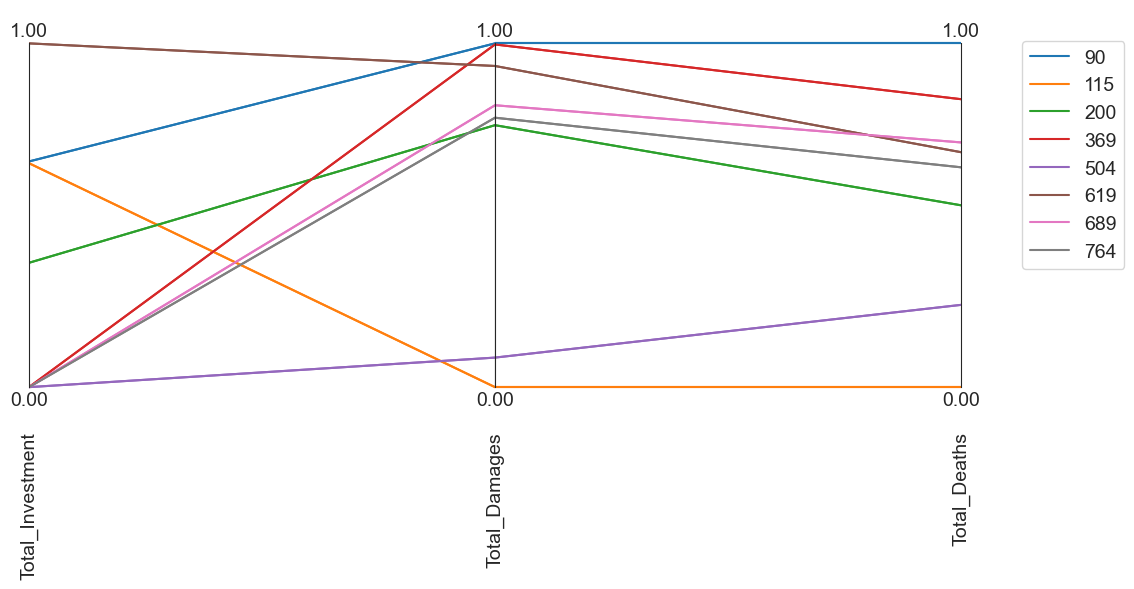

In [54]:

data = scores.loc[:, ["Total_Investment",
                        "Total_Damages",
                        "Total_Deaths",
                        ]]
data = ((data-data.min())/(data.max()-data.min()))
limits = parcoords.get_limits(data)
limits.loc[0, :] = 0
paraxes = parcoords.ParallelAxes(limits)
for j, (ind, row) in enumerate(data.reset_index().iterrows()):
            paraxes.plot(row.to_frame().T, label=int(row['index']), color=colors[j])
paraxes.legend()
paraxes.plot(data)
plt.show()

        

##### 3c2 Calculate Regret

In [58]:
def calculate_regret(data, best):
    return np.abs(best-data)

In [59]:
experiments, outcomes = rob_results
overall_regret = {}
max_regret = {}
for outcome in model.outcomes:
    policy_column = experiments['policy']
    
    # create a DataFrame with all the relevant information
    # i.e., policy, scenario_id, and scores
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    # reorient the data by indexing with policy and scenario id
    data = data.pivot(index='scenario', columns='policy')
    
    # flatten the resulting hierarchical index resulting from 
    # pivoting, (might be a nicer solution possible)
    data.columns = data.columns.get_level_values(1)
    
    # Convert your DataFrame to a numpy array before multi-dimensional indexing
    data_array = data.to_numpy()

    # we need to control the broadcasting. 
    # max returns a 1d vector across scenario id. By passing
    # np.newaxis we ensure that the shape is the same as the data
    # next we take the absolute value
    #
    # basically we take the difference of the maximum across 
    # the row and the actual values in the row
    #
    outcome_regret = np.abs(data_array.max(axis=1)[:, np.newaxis] - data_array)
    # Convert numpy array back to DataFrame
    outcome_regret_df = pd.DataFrame(outcome_regret, index=data.index, columns=data.columns)
    
    overall_regret[outcome.name] = outcome_regret_df
    max_regret[outcome.name] = outcome_regret_df.max()


visualize as heatmap

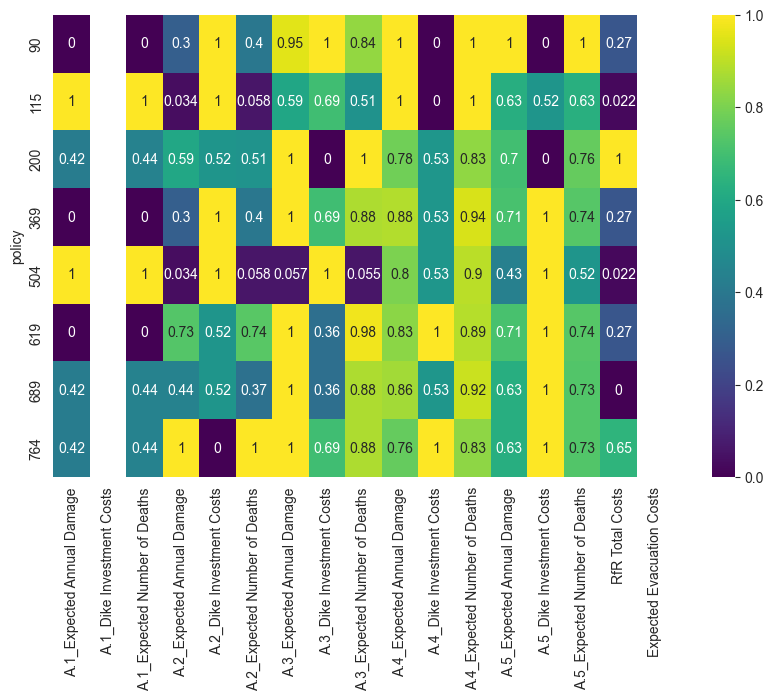

In [60]:
max_regret = pd.DataFrame(max_regret)
sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
plt.show()

visualize as parallel axis

c:\Users\varun\anaconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:219: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)
c:\Users\varun\anaconda3\lib\site-packages\ema_workbench\analysis\parcoords.py:280: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


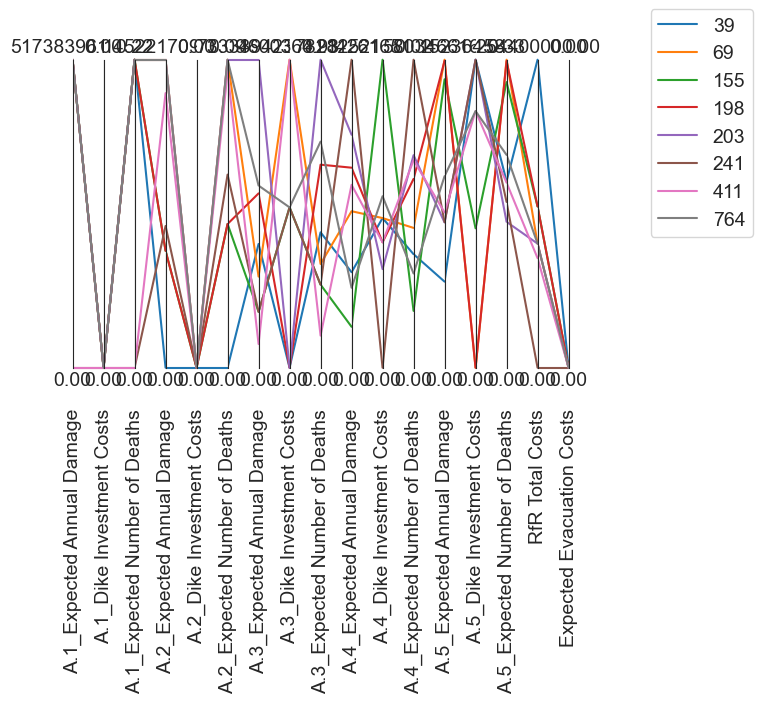

In [22]:
colors = sns.color_palette()

data = max_regret

# makes it easier to identify the policy associated with each line
# in the parcoords plot
# data['policy'] = data.index.astype("float64")

limits = parcoords.get_limits(data)
limits.loc[0, :] = 0

paraxes = parcoords.ParallelAxes(limits)
for i, (index, row) in enumerate(data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
paraxes.legend()
    
plt.show()